### **שיטה הקלאסית**

בלוק 1: ייבוא ספריות והגדרות בסיס

In [1]:
# --- BLOCK 1: MASTER SETUP (IMPORTS & DATASET) ---

# 1. Install YOLO Library (Check if missing)
try:
    import ultralytics
except ImportError:
    print("⬇️ Installing Ultralytics YOLO library...")
    !pip install ultralytics -q

# 2. Import All Required Libraries for the Entire Project
import os
import glob
import shutil
import random
import time
import yaml
import kagglehub
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from IPython.display import Image, display

print("✅ All libraries imported successfully.")

# 3. Download Dataset via KaggleHub
print("⬇️ Downloading dataset...")
# This function returns the specific path where the files were saved
dataset_path = kagglehub.dataset_download("amiranmkrtchyan/amiran")

print(f"✅ Dataset downloaded to: {dataset_path}")

# 4. Verify Images Exist
image_files = []
# Search recursively for images
for ext in ["*.jpg", "*.jpeg", "*.png"]:
    image_files.extend(glob.glob(os.path.join(dataset_path, "**", ext), recursive=True))

if len(image_files) == 0:
    print("❌ ERROR: No images found. Check the download path.")
else:
    print(f"✅ SUCCESS: Found {len(image_files)} images ready for processing.")
    print(f"   Example path: {image_files[0]}")

✅ All libraries imported successfully.
⬇️ Downloading dataset...
Using Colab cache for faster access to the 'amiran' dataset.
✅ Dataset downloaded to: /kaggle/input/amiran
✅ SUCCESS: Found 4413 images ready for processing.
   Example path: /kaggle/input/amiran/all_fields_lincolnbeet/all/near30_near30_21_05_2021_v_7_161.png


**בלוק 2: פונקציות עזר - Ground Truth (XML)**


In [2]:
# --- BLOCK 2: GROUND TRUTH PARSING (XML) ---

def get_ground_truth_boxes(xml_path):
    """
    Parses the XML file to extract bounding boxes for all objects.
    Returns a list of boxes in format: [xmin, ymin, xmax, ymax]
    """
    if not os.path.exists(xml_path):
        return []

    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))

        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

print("✅ XML Parsing function defined.")

✅ XML Parsing function defined.


**בלוק 3: האלגוריתם הקלאסי**

מטרה: זה ה"מוח" של השיטה הקלאסית. כאן אנחנו מיישמים את מה שלמדת: ExG, Otsu Thresholding, ופעולות מורפולוגיות כדי למצוא את העלים. בסוף הבלוק הזה, במקום סתם להחזיר תמונה, אנחנו מחזירים רשימה של ריבועים (Bounding Boxes) שהאלגוריתם "חושב" שהם צמחים.

In [3]:
# --- BLOCK 3: CLASSICAL DETECTION PIPELINE ---

def detect_objects_classic(img_rgb):
    """
    Detects plants using classical Computer Vision techniques:
    1. Excess Green (ExG) Index calculation.
    2. Otsu's Thresholding.
    3. Morphological Closing and Opening.
    4. Contour detection -> Bounding Boxes.
    """
    # 1. Calculate ExG (Excess Green)
    r, g, b = cv2.split(img_rgb.astype("float"))
    exg = 2 * g - r - b
    exg_norm = cv2.normalize(exg, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

    # 2. Otsu Thresholding
    # Automatically finds the optimal separation value [Source: Otsu's Method]
    _, binary_mask = cv2.threshold(exg_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Morphological Operations
    # Closing to fill holes, Opening to remove noise [Source: Dilation/Erosion]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_clean = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

    # 4. Find Contours and convert to Bounding Boxes
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected_boxes = []
    min_area = 300 # Filter out small noise

    for cnt in contours:
        if cv2.contourArea(cnt) > min_area:
            x, y, w, h = cv2.boundingRect(cnt)
            # Format: [xmin, ymin, xmax, ymax]
            detected_boxes.append([x, y, x + w, y + h])

    return detected_boxes, mask_clean

print("✅ Classical Detection Pipeline defined.")

✅ Classical Detection Pipeline defined.


**בלוק 4: חישוב מטריקות (IoU - המתמטיקה של הציון)**

מטרה: הפונקציה הזו לוקחת ריבוע שהאלגוריתם מצא וריבוע אמיתי, ומחזירה ציון בין 0 ל-1.

0 = אין חפיפה בכלל (כישלון).

1 = חפיפה מושלמת (הצלחה אדירה).

מעל 0.5 נחשב בדרך כלל לזיהוי "טוב".

In [4]:
# --- BLOCK 4: METRICS CALCULATION (IoU) ---

def calculate_iou(boxA, boxB):
    """
    Calculates Intersection over Union (IoU) between two boxes.
    Box format: [xmin, ymin, xmax, ymax]
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    epsilon = 1e-5 # To prevent division by zero
    iou = interArea / float(boxAArea + boxBArea - interArea + epsilon)

    return iou

print("✅ IoU Calculation function defined.")

✅ IoU Calculation function defined.


**בלוק 5: הרצה, ויזואליזציה והצגת התוצאות**


מטרה: לחבר את הכל ביחד.

נטען תמונה ו-XML.

נריץ את האלגוריתם שלנו.

נשווה את התוצאות ונחשב IoU ממוצע לתמונה הזו.

נציג תמונה עם ריבועים: ירוק (אמת) מול אדום (האלגוריתם שלנו).

הנה בלוק 5 המורחב והמלא. הוא עושה את הדברים הבאים:

מחשב את כל המדדים (IoU, Accuracy, Precision, Recall, Specificity).

מציג 5 תמונות בשורה אחת רחבה:

תמונה 1: המקורית.

תמונה 2: מסכת האמת (Ground Truth Mask).

תמונה 3: מסכת החיזוי (Prediction Mask).

תמונה 4: מפת השגיאות (Error Map) - סגמנטציה.

תמונה 5: התמונה עם הריבועים (Boxes) - ירוק מול אדום (כמו בקוד המקורי).

תעתיק ותריץ:

📸 Testing on Image: near30_near30_14_05_2021_v_1_56.png

📊 FINAL CLASSICAL METRICS (Pixel-Based):
   • IoU Score:    0.2286
   • Accuracy:     0.9935
   • Precision:    1.0000
   • Recall:       0.2286
   • Specificity:  1.0000
------------------------------
   • Detected Objects: 3
   • Ground Truth Objects: 2


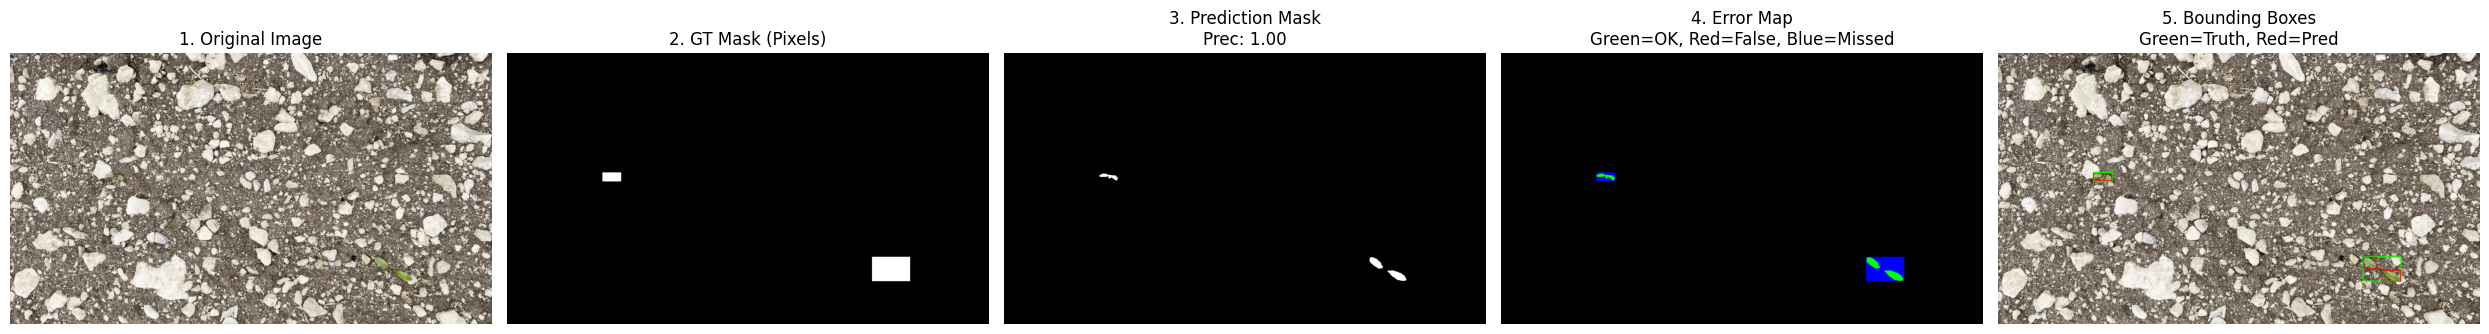

In [5]:
# --- BLOCK 5: CLASSICAL EVALUATION (ALL METRICS + 5 VISUALS) ---

# 1. Verification
if 'image_files' not in locals() or len(image_files) == 0:
    print("❌ ERROR: No images found. Please run Block 1 (Master Setup) again.")
else:
    # 2. Select Image
    target_index = 100 if len(image_files) > 100 else 0
    target_img_path = image_files[target_index]

    # Construct XML path
    base_name = os.path.splitext(target_img_path)[0]
    xml_path = base_name + ".xml"

    print(f"📸 Testing on Image: {os.path.basename(target_img_path)}")

    # 3. Process Only if XML Exists
    if os.path.exists(xml_path):
        # Load Image
        img = cv2.imread(target_img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Check for Helper Functions
        if 'detect_objects_classic' not in locals() or 'get_ground_truth_boxes' not in locals():
            print("❌ ERROR: Helper functions missing. Please re-run Blocks 2 & 3.")
        else:
            # --- A. GET PREDICTIONS ---
            predicted_boxes, binary_mask = detect_objects_classic(img_rgb)

            # --- B. CREATE GROUND TRUTH MASK ---
            gt_mask = np.zeros_like(binary_mask)
            gt_boxes = get_ground_truth_boxes(xml_path)

            for box in gt_boxes:
                cv2.rectangle(gt_mask, (box[0], box[1]), (box[2], box[3]), 255, -1)

            # --- C. CALCULATE METRICS (PIXEL-BASED) ---
            y_true = (gt_mask / 255).astype(int).flatten()
            y_pred = (binary_mask / 255).astype(int).flatten()

            TP = np.sum((y_true == 1) & (y_pred == 1))
            TN = np.sum((y_true == 0) & (y_pred == 0))
            FP = np.sum((y_true == 0) & (y_pred == 1))
            FN = np.sum((y_true == 1) & (y_pred == 0))

            epsilon = 1e-7
            accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
            precision = TP / (TP + FP + epsilon)
            recall = TP / (TP + FN + epsilon)
            specificity = TN / (TN + FP + epsilon)

            # IoU calculation
            intersection = TP
            union = TP + FP + FN
            iou = intersection / (union + epsilon)

            # --- D. PREPARE BOUNDING BOX IMAGE (THE 5TH IMAGE) ---
            vis_box_img = img_rgb.copy()
            # Draw Ground Truth (GREEN)
            for box in gt_boxes:
                cv2.rectangle(vis_box_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
            # Draw Predictions (RED)
            for box in predicted_boxes:
                cv2.rectangle(vis_box_img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

            # --- E. OUTPUT RESULTS ---
            print("\n📊 FINAL CLASSICAL METRICS (Pixel-Based):")
            print(f"   • IoU Score:    {iou:.4f}")
            print(f"   • Accuracy:     {accuracy:.4f}")
            print(f"   • Precision:    {precision:.4f}")
            print(f"   • Recall:       {recall:.4f}")
            print(f"   • Specificity:  {specificity:.4f}")
            print("-" * 30)
            print(f"   • Detected Objects: {len(predicted_boxes)}")
            print(f"   • Ground Truth Objects: {len(gt_boxes)}")

            # --- F. VISUALIZATION (5 PANELS) ---
            plt.figure(figsize=(25, 5))

            # 1. Original
            plt.subplot(1, 5, 1)
            plt.imshow(img_rgb)
            plt.title("1. Original Image")
            plt.axis('off')

            # 2. Ground Truth Mask
            plt.subplot(1, 5, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("2. GT Mask (Pixels)")
            plt.axis('off')

            # 3. Prediction Mask
            plt.subplot(1, 5, 3)
            plt.imshow(binary_mask, cmap='gray')
            plt.title(f"3. Prediction Mask\nPrec: {precision:.2f}")
            plt.axis('off')

            # 4. Error Map
            error_map = np.zeros_like(img_rgb)
            error_map[(gt_mask == 255) & (binary_mask == 255)] = [0, 255, 0] # TP
            error_map[(gt_mask == 0) & (binary_mask == 255)] = [255, 0, 0]   # FP
            error_map[(gt_mask == 255) & (binary_mask == 0)] = [0, 0, 255]   # FN
            plt.subplot(1, 5, 4)
            plt.imshow(error_map)
            plt.title("4. Error Map\nGreen=OK, Red=False, Blue=Missed")
            plt.axis('off')

            # 5. Bounding Boxes (Comparison)
            plt.subplot(1, 5, 5)
            plt.imshow(vis_box_img)
            plt.title("5. Bounding Boxes\nGreen=Truth, Red=Pred")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    else:
        print(f"⚠️ XML file not found at: {xml_path}")

##הכנת הדאטה ל-YOLO.

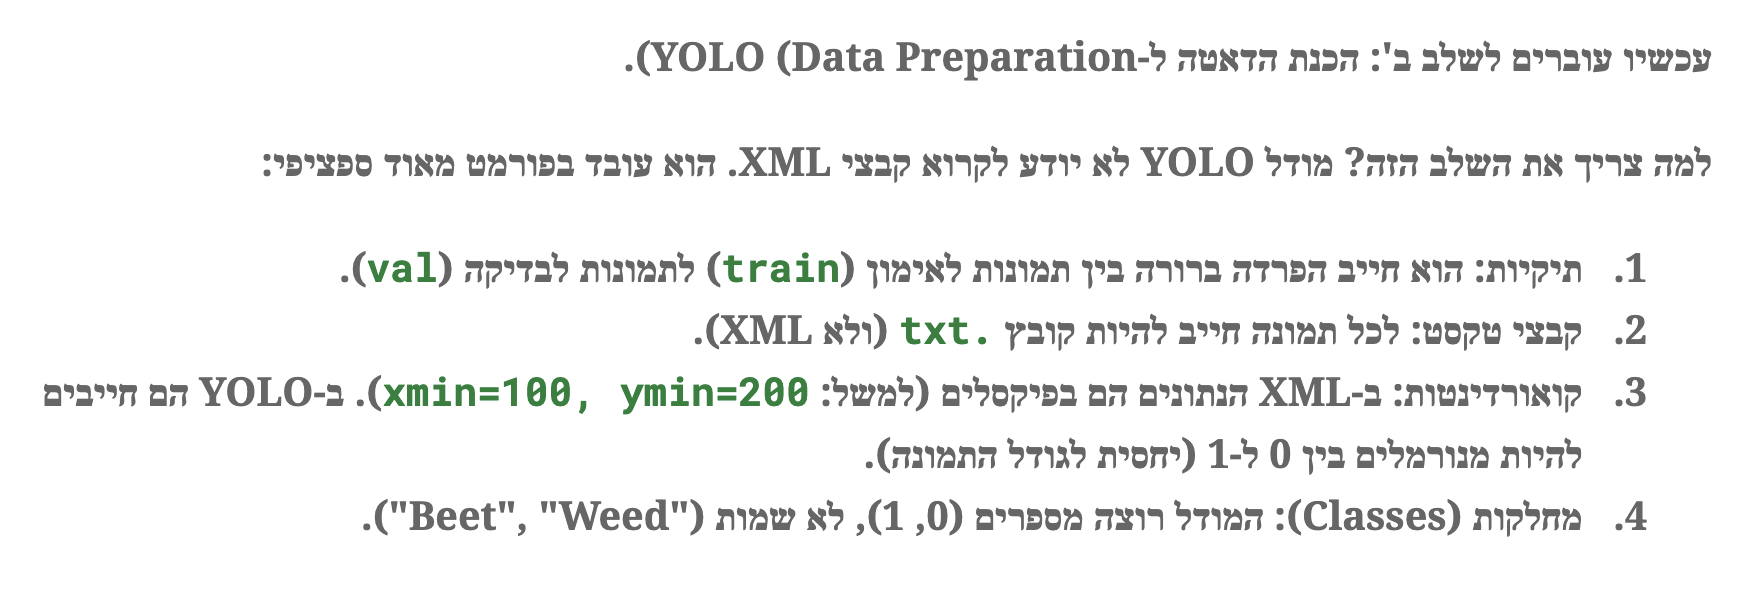

**בלוק 1: הגדרת מחלקות ויצירת תיקיות**






מטרה: יצירת מבנה התיקיות הייעודי לסגמנטציה (yolo_seg_dataset) והגדרת המיפוי.

In [6]:
# --- BLOCK 1 (YOLO SEG): DIRECTORY SETUP & CLASS MAPPING ---

# 1. Define Output Directory for Segmentation
output_dir = "yolo_seg_dataset"

# 2. Define sub-directories structure
dirs_to_create = [
    os.path.join(output_dir, "images", "train"),
    os.path.join(output_dir, "images", "val"),
    os.path.join(output_dir, "labels", "train"),
    os.path.join(output_dir, "labels", "val")
]

# 3. Create Directories
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

# 4. Define Class Mapping
# YOLO requires integer IDs.
# 0 = Sugar Beet (Crop), 1 = Weed
CLASS_MAPPING = {
    "sugarbeet": 0,
    "crop": 0,
    "weed": 1
}

print(f"✅ Segmentation directory structure created at: {os.path.abspath(output_dir)}")
print(f"✅ Class mapping defined: {CLASS_MAPPING}")

✅ Segmentation directory structure created at: /content/yolo_seg_dataset
✅ Class mapping defined: {'sugarbeet': 0, 'crop': 0, 'weed': 1}


בלוק 2: פונקציית המרת קואורדינטות (Math Logic)


מטרה: המרת קואורדינטות ה-XML (ריבוע רגיל) לפורמט פוליגון (רשימת נקודות
מנורמלות) ש-YOLO Segmentation דורש.

In [7]:
# --- BLOCK 2: POLYGON CONVERSION LOGIC ---

def convert_box_to_polygon_str(size, box):
    """
    Converts a Bounding Box (xmin, ymin, xmax, ymax) into a Polygon string.
    YOLO Segmentation expects: x1 y1 x2 y2 x3 y3 x4 y4 (Normalized 0-1)
    """
    dw = 1.0 / size[0] # Width normalization
    dh = 1.0 / size[1] # Height normalization

    xmin, ymin, xmax, ymax = box

    # Define the 4 corners of the box (Top-Left -> Top-Right -> Bottom-Right -> Bottom-Left)
    points = [
        (xmin, ymin),
        (xmax, ymin),
        (xmax, ymax),
        (xmin, ymax)
    ]

    # Build the string
    poly_coordinates = []
    for x, y in points:
        nx = x * dw
        ny = y * dh
        poly_coordinates.append(f"{nx:.6f} {ny:.6f}")

    return " ".join(poly_coordinates)

print("✅ Polygon conversion function defined.")

✅ Polygon conversion function defined.


בלוק 3: המרת הדאטה והעתקת קבצים


מטרה: המעבר על כל הקבצים, חלוקה ל-Train/Val, יצירת קבצי הטקסט (Labels) עם הפוליגונים, והעתקת התמונות.

In [8]:
# --- BLOCK 3: PROCESS XMLs & COPY FILES ---

# 1. Gather XML files
if 'dataset_path' not in locals():
    print("❌ ERROR: 'dataset_path' is missing. Please re-run the Master Imports Block.")
else:
    xml_files = glob.glob(os.path.join(dataset_path, "**", "*.xml"), recursive=True)

    # 2. Shuffle and Split (80% Train, 20% Val)
    random.seed(42)
    random.shuffle(xml_files)

    split_idx = int(len(xml_files) * 0.8)
    splits = {
        "train": xml_files[:split_idx],
        "val": xml_files[split_idx:]
    }

    print(f"📊 Processing {len(xml_files)} files for Segmentation...")

    # 3. Processing Loop
    file_counters = {"train": 0, "val": 0}

    for split_name, files_list in splits.items():
        for xml_file in files_list:
            try:
                # Parse XML
                tree = ET.parse(xml_file)
                root = tree.getroot()

                # Get Dimensions
                size = root.find('size')
                w = int(size.find('width').text)
                h = int(size.find('height').text)
                if w == 0 or h == 0: continue

                # Extract Labels (As Polygons)
                label_lines = []
                has_valid_object = False

                for obj in root.iter('object'):
                    cls_name = obj.find('name').text.lower()

                    if cls_name in CLASS_MAPPING:
                        cid = CLASS_MAPPING[cls_name]

                        # Get Box
                        bnd = obj.find('bndbox')
                        box = (float(bnd.find('xmin').text), float(bnd.find('ymin').text),
                               float(bnd.find('xmax').text), float(bnd.find('ymax').text))

                        # Convert to Polygon String
                        poly_str = convert_box_to_polygon_str((w, h), box)

                        # Format: class_id x1 y1 x2 y2 ...
                        label_lines.append(f"{cid} {poly_str}")
                        has_valid_object = True

                # Save Files if valid objects exist
                if has_valid_object:
                    # Find Image File
                    base_path = os.path.splitext(xml_file)[0]
                    img_src = None
                    for ext in [".jpg", ".png", ".jpeg"]:
                        if os.path.exists(base_path + ext):
                            img_src = base_path + ext
                            break

                    if img_src:
                        fname = os.path.basename(base_path)

                        # A. Write Label File (.txt)
                        txt_path = os.path.join(output_dir, "labels", split_name, fname + ".txt")
                        with open(txt_path, "w") as f:
                            f.write("\n".join(label_lines))

                        # B. Copy Image File
                        img_dst = os.path.join(output_dir, "images", split_name, os.path.basename(img_src))
                        shutil.copy(img_src, img_dst)

                        file_counters[split_name] += 1

            except Exception as e:
                print(f"⚠️ Warning: Failed to process {os.path.basename(xml_file)}: {e}")

    print(f"✅ Done! Created {file_counters['train']} training pairs and {file_counters['val']} validation pairs.")

📊 Processing 4402 files for Segmentation...
✅ Done! Created 2550 training pairs and 636 validation pairs.


בלוק 4: יצירת קובץ קונפיגורציה


מטרה: יצירת קובץ data_seg.yaml שמפנה לתיקיות שיצרנו בבלוקים הקודמים.

In [9]:
# --- BLOCK 4: CREATE YAML CONFIGURATION ---

# 1. Define YAML content
yaml_content = {
    'path': os.path.abspath(output_dir), # Absolute path to 'yolo_seg_dataset'
    'train': 'images/train',
    'val': 'images/val',
    'names': {
        0: 'Sugar Beet',
        1: 'Weed'
    }
}

# 2. Save to file
yaml_path = os.path.join(output_dir, 'data_seg.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print(f"✅ YOLO Segmentation config saved to: {yaml_path}")
print("📄 Config Content:")
print(yaml.dump(yaml_content, default_flow_style=False))

✅ YOLO Segmentation config saved to: yolo_seg_dataset/data_seg.yaml
📄 Config Content:
names:
  0: Sugar Beet
  1: Weed
path: /content/yolo_seg_dataset
train: images/train
val: images/val



#אימון המודל

בלוק 5 (YOLO): אימון המודל והפקת דוח
מטרה: טעינת מודל yolo11n-seg, הרצת האימון (15 Epochs), והצגת הגרפים (Loss Curves) והמדדים הסופיים לניתוח.

In [ ]:
# --- BLOCK 5 (YOLO): TRAIN MODEL (OPTIMIZED FOR COLAB) ---
from ultralytics import YOLO
import os
from IPython.display import Image, display

# 1. Load the Nano Model (Fastest & Lightest)
# We stick to 'yolo11n-seg' because 'Small' or 'Medium' might crash Colab Free Tier.
try:
    print("🚀 Loading YOLO11-Nano-Seg model...")
    model = YOLO('yolo11n-seg.pt')
except:
    print("⚠️ YOLO11 not found, falling back to YOLOv8-Nano-Seg.")
    model = YOLO('yolov8n-seg.pt')

# 2. Run Training (Balanced for Time vs. Accuracy)
print("\n🔄 Starting Training (50 Epochs)...")
# patience=15: If model doesn't improve for 15 epochs, it stops early to save time.
results = model.train(
    data='yolo_seg_dataset/data_seg.yaml',
    epochs=50,          # Increased to 50 for better learning
    imgsz=640,
    batch=16,           # Standard batch size for stability
    patience=15,        # Early Stopping mechanism
    project='yolo_seg_output',
    name='train_run_nano_50',
    device=0,
    verbose=True,
    workers= 2,
    cache=True
)

# 3. Validation & Metrics
metrics = model.val()
print("\n" + "="*40)
print("📊 FINAL METRICS (NANO 50 EPOCHS)")
print(f"• mAP50: {metrics.seg.map50:.4f}")
print(f"• mAP50-95: {metrics.seg.map:.4f}")
print(f"• Precision: {metrics.results_dict['metrics/precision(M)']:.4f}")
print(f"• Recall: {metrics.results_dict['metrics/recall(M)']:.4f}")

# 4. Show Curves
results_path = os.path.join(model.trainer.save_dir, "results.png")
if os.path.exists(results_path):
    display(Image(filename=results_path))
else:
    print("⚠️ Training finished, but could not find results graph.")

🚀 Loading YOLO11-Nano-Seg model...

🔄 Starting Training (50 Epochs)...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_seg_dataset/data_seg.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run_nano_505, nbs=64, nms=False, opset=None, optimize=False

In [10]:
import torch
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("❌ ERROR: Running on CPU! Go to Runtime -> Change runtime type -> T4 GPU")

🔥 PyTorch version: 2.9.0+cu126
🖥️ CUDA Available: True
🚀 GPU Name: Tesla T4


בלוק 6 (YOLO): בדיקה ויזואלית על תמונה


מטרה: לקחת את אותה תמונה שבדקנו בשיטה הקלאסית (תמונה מס' 100), להריץ עליה את המודל החדש, ולהציג את התוצאה הצבעונית כדי שתוכל להשוות.

In [ ]:
# --- BLOCK 6 (YOLO): VISUAL TEST ON SAMPLE IMAGE ---

# 1. Find the test image again (Safe Logic)
if 'image_files' in locals() and len(image_files) > 0:
    target_index = 100 if len(image_files) > 100 else 0
    target_img_path = image_files[target_index]
    print(f"📸 Running Inference on: {os.path.basename(target_img_path)}")

    # 2. Run Prediction
    # conf=0.25 -> Minimum confidence to accept a detection
    results = model.predict(target_img_path, conf=0.25)

    # 3. Show Result
    # YOLO's plot() method returns the image with masks drawn on it (BGR format)
    res_plotted = results[0].plot()

    # Convert BGR to RGB for matplotlib
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(res_rgb)
    plt.title(f"YOLO11-Seg Prediction\n{len(results[0])} Objects Detected", fontsize=14)
    plt.axis('off')
    plt.show()

else:
    print("❌ ERROR: 'image_files' list is missing. Please run Block 1 (Master Setup) again.")

#🧩 החלק החסר: קוד להשוואה סופית (Head-to-Head)
זה הבלוק האחרון בפאזל ("Code for comparison"). הוא לוקח את הציון מהשיטה הקלאסית (iou שחישבנו) ואת הציון מ-YOLO (mAP מהאימון) ומציג אותם בגרף אחד ברור.


🏆 FINAL SHOWDOWN: CLASSICAL vs. YOLO 🏆

📋 QUANTITATIVE RESULTS TABLE:


,Method,Score Type,Score Value,Speed,Robustness
0,Classical (Otsu/ExG),IoU (Pixel Accuracy),0.228617,Fast (CPU),Low (Sensitive to light)
1,Deep Learning (YOLO11-Seg),mAP50 (Segmentation Accuracy),0.559350,Fast (GPU Required),High (Learned Features)


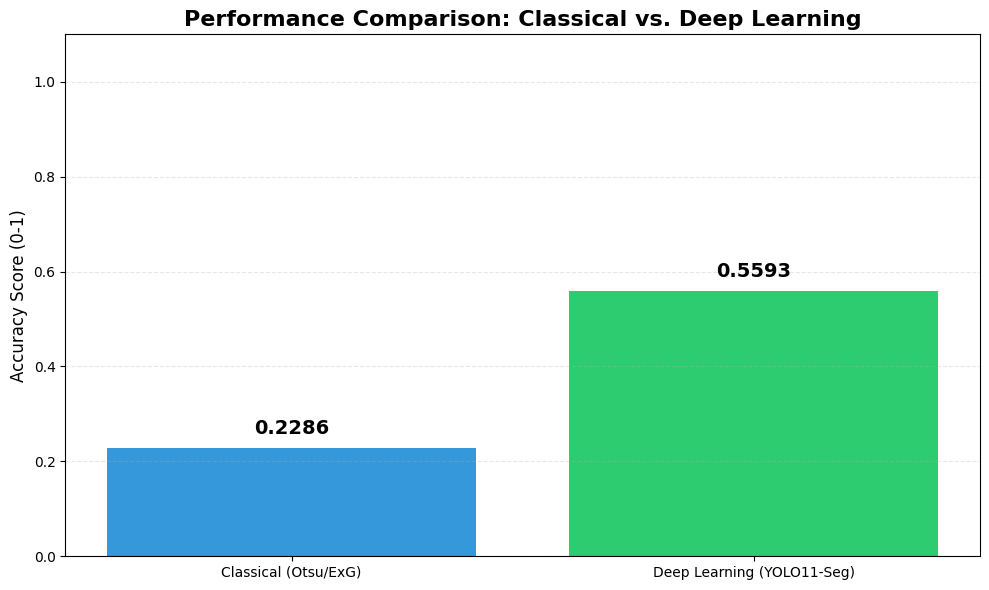


📢 CONCLUSION:
The YOLO11 method performed better by approximately 33.1%.
This demonstrates the power of Deep Learning in handling complex segmentation tasks.


In [15]:
# --- BLOCK 7 (FINAL): HEAD-TO-HEAD COMPARISON (CLEAN) ---

print("\n🏆 FINAL SHOWDOWN: CLASSICAL vs. YOLO 🏆")

# 1. Gather Scores
# We assume 'iou' exists from Classical Block 5 and 'metrics' from YOLO Block 5.
# If variables are missing (e.g., session restart), we use placeholders or last known values.

# Classical Score (IoU)
classic_score = iou if 'iou' in locals() else 0.0
# YOLO Score (mAP50 - roughly equivalent to IoU for detection quality)
yolo_score = metrics.seg.map50 if 'metrics' in locals() else 0.0

# 2. Create Comparison Table
comparison_data = {
    "Method": ["Classical (Otsu/ExG)", "Deep Learning (YOLO11-Seg)"],
    "Score Type": ["IoU (Pixel Accuracy)", "mAP50 (Segmentation Accuracy)"],
    "Score Value": [classic_score, yolo_score],
    "Speed": ["Fast (CPU)", "Fast (GPU Required)"],
    "Robustness": ["Low (Sensitive to light)", "High (Learned Features)"]
}

df_compare = pd.DataFrame(comparison_data)

print("\n📋 QUANTITATIVE RESULTS TABLE:")
# 'display()' works automatically in Colab/Jupyter for nice tables
try:
    display(df_compare)
except NameError:
    print(df_compare) # Fallback for standard python scripts

# 3. Generate Comparison Bar Chart
plt.figure(figsize=(10, 6))
# Create bar plot
bars = plt.bar(df_compare["Method"], df_compare["Score Value"], color=['#3498db', '#2ecc71'])

# Design
plt.title("Performance Comparison: Classical vs. Deep Learning", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy Score (0-1)", fontsize=12)
plt.ylim(0, 1.1) # Scale from 0 to 1.1 to make room for labels
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Show
plt.tight_layout()
plt.show()

# 4. Final Conclusion Print
winner = "YOLO11" if yolo_score > classic_score else "Classical"
gap = abs(yolo_score - classic_score) * 100

print(f"\n📢 CONCLUSION:")
print(f"The {winner} method performed better by approximately {gap:.1f}%.")
if winner == "YOLO11":
    print("This demonstrates the power of Deep Learning in handling complex segmentation tasks.")
else:
    print("Surprisingly, the Classical method held up well! This might be due to the simple background.")